In [1]:
!pip install pynamics
%matplotlib inline
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import AccelerationConstraint
import pynamics.integration
import numpy
import sympy
import matplotlib.pyplot as plt
plt.ion()
from math import pi

In [ ]:
system=System()
pynamics.set_system(__name__,system)

In [ ]:
lA = Constant(.05,'lA',system)
lB = Constant(.05,'lB',system)

mA = Constant(1,'mA',system)
mB = Constant(1,'mB',system)

g = Constant(9.81,'g',system)     #Gravity 
b = Constant(1e-1,'b',system)
k = Constant(1e-1,'k',system)

preload1 = Constant(-120*pi/180,'preload1',system)
preload2 = Constant(15*pi/180,'preload2',system)

Ixx_A = Constant(1,'Ixx_A',system)    #Inertial values that describe te dyatics/inertia of the rigid bodies about x, y and z axes 
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(1,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)

torque = Constant(0,'torque',system)
freq = Constant(3e0,'freq',system)  #3e0 means 3Hz

In [ ]:
qA,qA_d,qA_dd = Differentiable('qA',system)     #3 state variables: qA, qA_d,qA_dd
qB,qB_d,qB_dd = Differentiable('qB',system)

In [ ]:
initialvalues = {}
initialvalues[qA]=-120*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=15*pi/180
initialvalues[qB_d]=0*pi/180

In [ ]:
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

In [ ]:
#Defining reference frames of the system 
N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)

In [ ]:
system.set_newtonian(N)

In [ ]:
A.rotate_fixed_axis(N,[0,0,1],qA,system)
B.rotate_fixed_axis(A,[0,0,1],qB,system)

In [ ]:
pNA=0*N.x
pAB=pNA+lA*A.x
pBtip = pAB + lB*B.x

In [ ]:
pAcm=pNA+lA/2*A.x   #Center of mass
pBcm=pAB+lB/2*B.x

In [ ]:
wNA = N.get_w_to(A) #Angular velocity 
wNA


qA_d*N.z

In [ ]:
wAB = A.get_w_to(B)
wAB


qB_d*A.z

In [ ]:
vBtip = pBtip.time_derivative(N,system)

In [ ]:
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)  
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
#BodyC = Particle(pCcm,mC,'ParticleC',system)

In [ ]:
system.addforce(torque*sympy.sin(freq*2*sympy.pi*system.t)*A.z,wNA)     #2*pi*f - converting Hz to radians 

In [ ]:
system.addforce(-b*wNA,wNA)     # Damper forces
system.addforce(-b*wAB,wAB)


In [ ]:
system.add_spring_force1(k,(qA-preload1)*N.z,wNA)   #Spring forces
system.add_spring_force1(k,(qB-preload2)*A.z,wAB)


(<pynamics.force.Force at 0x7fa99d1bfb50>,
 <pynamics.spring.Spring at 0x7fa99d1bfa50>)

In [ ]:
system.addforcegravity(-g*N.y)

In [ ]:
f,ma = system.getdynamics()

2022-03-01 01:44:48,665 - pynamics.system - INFO - getting dynamic equations


In [ ]:
f

[-b*qA_d - g*lA*mA*cos(qA)/2 - g*lA*mB*cos(qA) + g*lB*mB*sin(qA)*sin(qB)/2 - g*lB*mB*cos(qA)*cos(qB)/2 - k*(-preload1 + qA) + torque*sin(2*freq*pi*t), -b*qB_d + g*lB*mB*sin(qA)*sin(qB)/2 - g*lB*mB*cos(qA)*cos(qB)/2 - k*(-preload2 + qB)]

In [ ]:
ma

[Izz_A*qA_dd + Izz_B*(qA_dd + qB_dd) + lA**2*mA*qA_dd/4 + lA**2*mB*qA_dd + lA*lB*mB*qA_d**2*sin(qB)/2 + lA*lB*mB*qA_dd*cos(qB)/2 - lA*lB*mB*(qA_d + qB_d)**2*sin(qB)/2 + lA*mB*(lB*qA_dd/2 + lB*qB_dd/2)*cos(qB) + lB*mB*(lB*qA_dd/2 + lB*qB_dd/2)/2, Izz_B*(qA_dd + qB_dd) + lA*lB*mB*qA_d**2*sin(qB)/2 + lA*lB*mB*qA_dd*cos(qB)/2 + lB*mB*(lB*qA_dd/2 + lB*qB_dd/2)/2]

In [ ]:
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)


2022-03-01 01:44:49,069 - pynamics.system - INFO - solving a = f/m and creating function
2022-03-01 01:44:49,179 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-03-01 01:44:49,313 - pynamics.system - INFO - done solving a = f/m and creating function
2022-03-01 01:44:49,324 - pynamics.system - INFO - calculating function for lambdas


In [ ]:
tol = 1e-5


In [ ]:
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [ ]:
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))


2022-03-01 01:44:49,420 - pynamics.integration - INFO - beginning integration
2022-03-01 01:44:49,422 - pynamics.system - INFO - integration at time 0000.00
2022-03-01 01:44:49,443 - pynamics.integration - INFO - finished integration


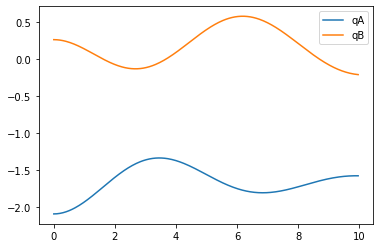

In [ ]:
plt.figure()
artists = plt.plot(t,states[:,:2])
plt.legend(artists,['qA','qB'])

2022-03-01 01:44:49,858 - pynamics.output - INFO - calculating outputs
2022-03-01 01:44:49,866 - pynamics.output - INFO - done calculating outputs


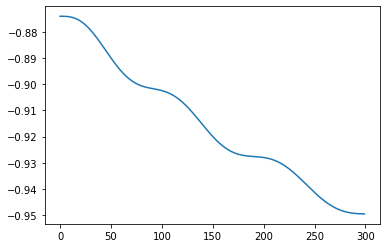

In [ ]:
KE = system.get_KE()
PE = system.getPEGravity(pNA) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time()

2022-03-01 01:44:50,198 - pynamics.output - INFO - calculating outputs
2022-03-01 01:44:50,206 - pynamics.output - INFO - done calculating outputs


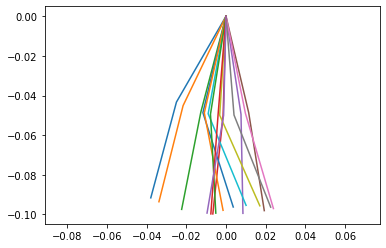

In [ ]:
points = [pNA,pAB,pBtip]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

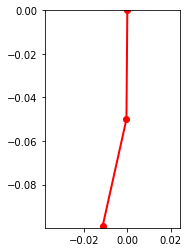

In [ ]:
points_output.animate(fps = fps,movie_name = 'triple_pendulum.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')


In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())